In [ ]:
!pip -q install scikit-image

In [ ]:
import os, re, tarfile, glob, random, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import cv2

plt.rcParams['figure.dpi'] = 120
random.seed(42)
np.random.seed(42)

print("Entorno listo.")

Entorno listo.


In [ ]:
import urllib.request

root_dir = os.path.abspath('./breakhis_data')
os.makedirs(root_dir, exist_ok=True)
tar_path = os.path.join(root_dir, 'BreaKHis_v1.tar.gz')

url = 'http://www.inf.ufpr.br/vri/databases/BreaKHis_v1.tar.gz'

try:
    if not os.path.exists(tar_path):
        print('Descargando BreaKHis... (puede tardar)')
        urllib.request.urlretrieve(url, tar_path)
        print('Descarga completa.')
    else:
        print('Archivo ya existe, saltando descarga.')
except Exception as e:
    print('No fue posible descargar automáticamente. Mensaje:', e)
    print('Sugerencia: monta Google Drive y usa una copia local del .tar.gz')

Descargando BreaKHis... (puede tardar)


KeyboardInterrupt: 

In [ ]:
extract_dir = os.path.join(root_dir, 'BreaKHis_v1')
if not os.path.exists(extract_dir):
    try:
        with tarfile.open(tar_path, 'r:gz') as tar:
            tar.extractall(path=root_dir)
        print('Extracción completa en:', extract_dir)
    except Exception as e:
        print('No fue posible extraer. Verifica la ruta del .tar.gz.\n', e)
else:
    print('Directorio extraído ya existe:', extract_dir)

/tmp/ipython-input-499906788.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=root_dir)


Extracción completa en: /content/breakhis_data/BreaKHis_v1


In [ ]:
pattern = re.compile(
    r"(?P<biopsy>SOB)_(?P<cls>[MB])_(?P<typ>[A-Z]+)-(?P<year>\d{2})-(?P<slide>[\w\d]+)-(?P<mag>40|100|200|400)-(?P<seq>\d+)\.png$"
)


image_paths = glob.glob(os.path.join(extract_dir, '**', '*.png'), recursive=True)
records = []
for p in image_paths:
    fname = os.path.basename(p)
    m = pattern.match(fname)
    if m:
        d = m.groupdict()
        patient_slide_id = d['slide']
        # Extract only the numeric part for the patient_id to prevent data leakage
        patient_id_match = re.match(r'(\d+)', patient_slide_id)
        actual_patient_id = patient_id_match.group(1) if patient_id_match else patient_slide_id

        records.append({
            'filepath': p,
            'tumor_class': 'malignant' if d['cls']=='M' else 'benign',
            'tumor_type': d['typ'],
            'patient_id': actual_patient_id,
            'magnification': int(d['mag'])
        })

df = pd.DataFrame(records)
print('Total imágenes parseadas:', len(df))
df.head()

Total imágenes parseadas: 7909


,filepath,tumor_class,tumor_type,patient_id,magnification
0,/content/breakhis_data/BreaKHis_v1/histology_s...,malignant,MC,13418,200
1,/content/breakhis_data/BreaKHis_v1/histology_s...,malignant,MC,13418,200
2,/content/breakhis_data/BreaKHis_v1/histology_s...,malignant,MC,13418,200
3,/content/breakhis_data/BreaKHis_v1/histology_s...,malignant,MC,13418,200
4,/content/breakhis_data/BreaKHis_v1/histology_s...,malignant,MC,13418,200


Distribución de clases:
 tumor_class
benign       2480
malignant    5429
Name: count, dtype: int64


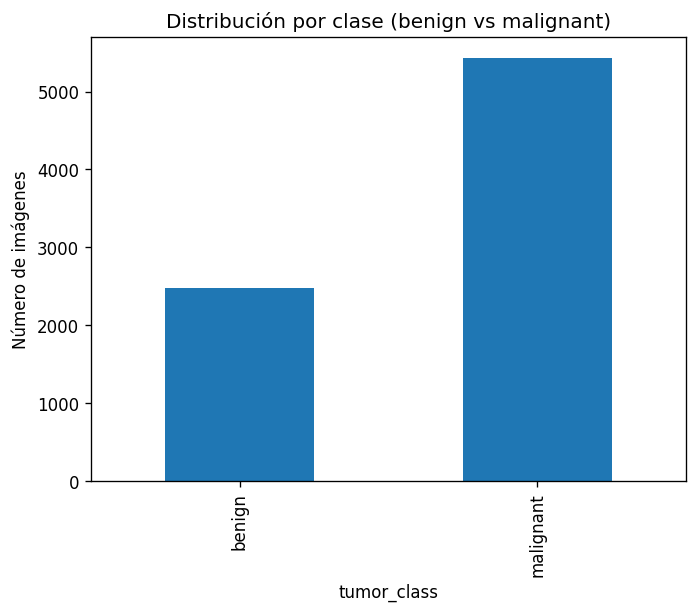


Imágenes por magnificación y clase:
 tumor_class    benign  malignant
magnification                   
40                625       1370
100               644       1437
200               623       1390
400               588       1232


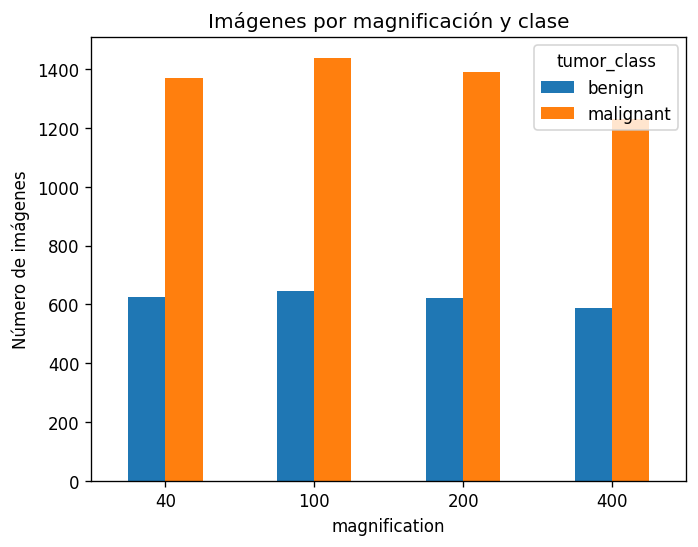


Top 15 pacientes por #imágenes:
 patient_id
21998    493
22549    383
15570    326
16184    256
13412    246
14134    236
16456    178
19979    160
22704    158
9461     155
12312    146
13993    145
2773     144
19440    142
23060    138
Name: count, dtype: int64


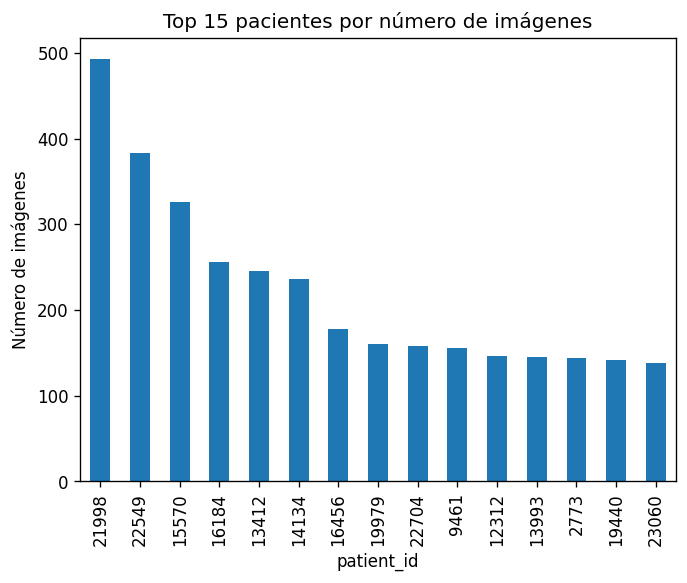

In [ ]:
cls_counts = df['tumor_class'].value_counts().sort_index()
print("Distribución de clases:\n", cls_counts)

ax = cls_counts.plot(kind='bar')
ax.set_title('Distribución por clase (benign vs malignant)')
ax.set_ylabel('Número de imágenes')
plt.show()

#  EDA: distribución por magnificación y clase
pivot_mag = df.pivot_table(index='magnification', columns='tumor_class',
                           values='filepath', aggfunc='count').fillna(0)
print("\nImágenes por magnificación y clase:\n", pivot_mag)

pivot_mag.plot(kind='bar', rot=0)
plt.title('Imágenes por magnificación y clase')
plt.ylabel('Número de imágenes')
plt.show()

#  EDA: imágenes por paciente (Top 15)
per_patient = df['patient_id'].value_counts().head(15)
print("\nTop 15 pacientes por #imágenes:\n", per_patient)

per_patient.plot(kind='bar')
plt.title('Top 15 pacientes por número de imágenes')
plt.ylabel('Número de imágenes')
plt.show()

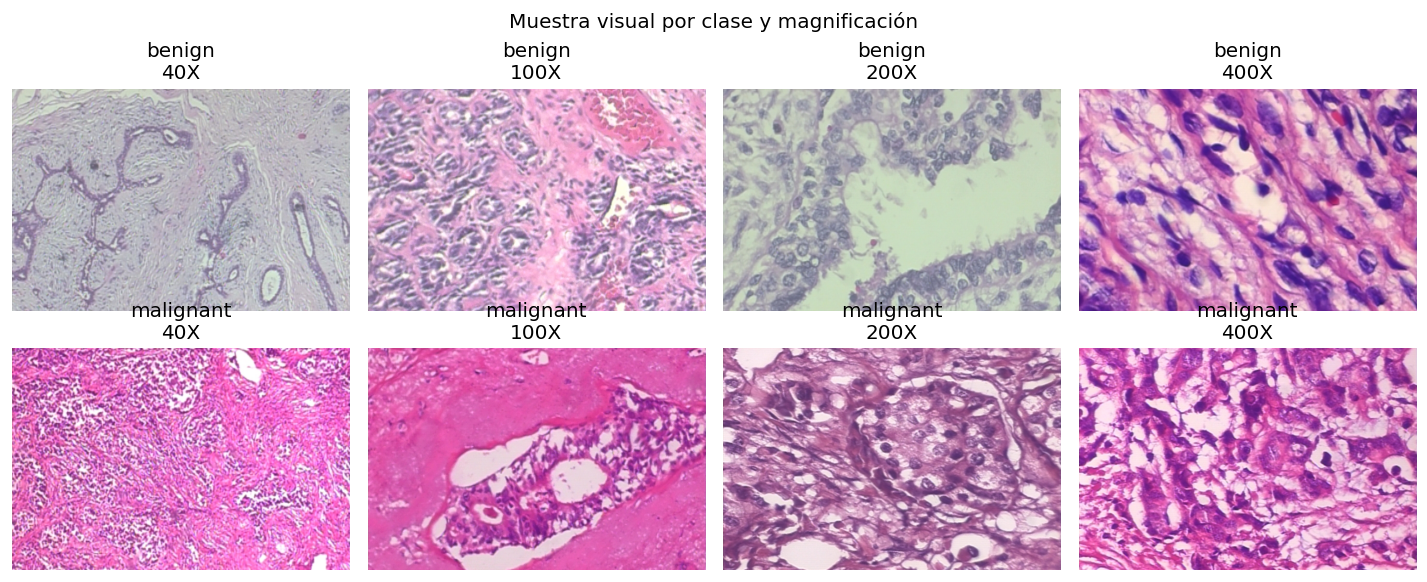

In [ ]:
def show_sample_grid(dataframe, by_class=('benign', 'malignant'),
                     mags=(40, 100, 200, 400), ncols=4):
    fig, axes = plt.subplots(len(by_class), ncols, figsize=(12, 5))
    for i, cls in enumerate(by_class):
        for j, m in enumerate(mags):
            subset = dataframe[(dataframe['tumor_class']==cls) & (dataframe['magnification']==m)]
            ax = axes[i, j]
            ax.axis('off')
            if len(subset)==0:
                ax.set_title(f'{cls}\n{m}X (sin data)')
                continue
            path = subset.sample(1, random_state=42)['filepath'].iloc[0]
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f'{cls}\n{m}X')
    plt.suptitle('Muestra visual por clase y magnificación')
    plt.tight_layout()
    plt.show()

show_sample_grid(df)

In [ ]:
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
groups = df['patient_id'].values

# train vs temp (val+test)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(gss1.split(df, groups=groups))
train_df = df.iloc[train_idx].copy()
temp_df  = df.iloc[temp_idx].copy()

# val vs test (50/50 de temp -> 15/15 del total)
groups_temp = temp_df['patient_id'].values
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(gss2.split(temp_df, groups=groups_temp))
val_df  = temp_df.iloc[val_idx].copy()
test_df = temp_df.iloc[test_idx].copy()

for name, part in [('train', train_df), ('val', val_df), ('test', test_df)]:
    print(name, len(part), 'imágenes, pacientes únicos:', part['patient_id'].nunique())

# Verificación: intersecciones vacías de pacientes
p_train, p_val, p_test = set(train_df['patient_id']), set(val_df['patient_id']), set(test_df['patient_id'])
print('Intersección train∩val:', p_train & p_val)
print('Intersección train∩test:', p_train & p_test)
print('Intersección val∩test:', p_val & p_test)

train 5624 imágenes, pacientes únicos: 49
val 1399 imágenes, pacientes únicos: 10
test 886 imágenes, pacientes únicos: 11
Intersección train∩val: set()
Intersección train∩test: set()
Intersección val∩test: set()


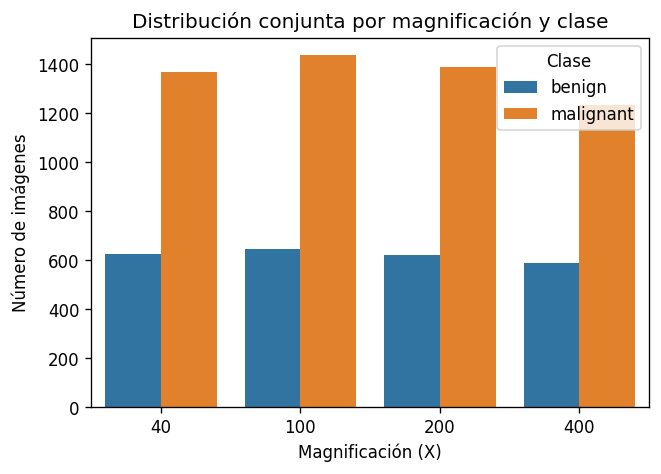

In [ ]:
  import seaborn as sns

  plt.figure(figsize=(6,4))
  sns.countplot(data=df, x='magnification', hue='tumor_class')
  plt.title('Distribución conjunta por magnificación y clase')
  plt.ylabel('Número de imágenes')
  plt.xlabel('Magnificación (X)')
  plt.legend(title='Clase')
  plt.show()

In [ ]:
#Proporciones exactas
prop = df['tumor_class'].value_counts(normalize=True).rename('proporción (%)') * 100
print("Proporción de clases (%):\n", prop.round(2))

Proporción de clases (%):
 tumor_class
malignant    68.64
benign       31.36
Name: proporción (%), dtype: float64


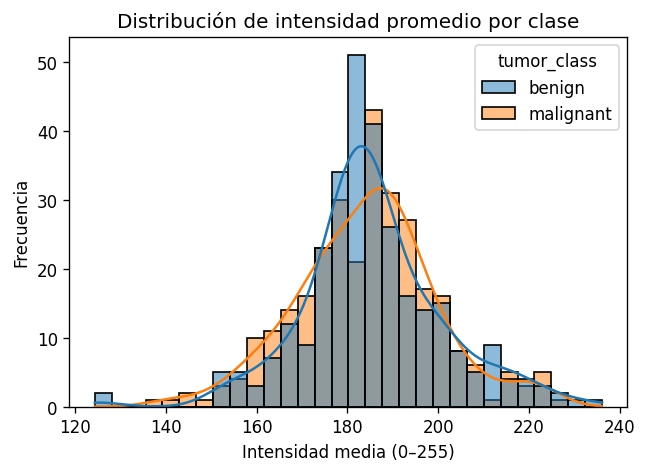

In [ ]:
# Histograma
def color_intensity(img_path):
    img = cv2.imread(img_path)
    return np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

sampled = df.groupby('tumor_class').sample(300, random_state=42)
sampled['intensity'] = sampled['filepath'].apply(color_intensity)

plt.figure(figsize=(6,4))
sns.histplot(data=sampled, x='intensity', hue='tumor_class', bins=30, kde=True)
plt.title('Distribución de intensidad promedio por clase')
plt.xlabel('Intensidad media (0–255)')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:

import os, time, random, json, math
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


In [ ]:

CLASS_TO_IDX = {'benign': 0, 'malignant': 1}

class HistologyDFDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, transform=None):
        self.frame = frame.reset_index(drop=True)
        self.transform = transform

    def __len__(self): return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]
        path = row['filepath']
        label = CLASS_TO_IDX[row['tumor_class']]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        return img, label, row['magnification'], row['patient_id'], path


In [ ]:
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])


In [ ]:
import os, re, glob, pandas as pd
from sklearn.model_selection import GroupShuffleSplit

def build_df_from_disk():
    root_dir = os.path.abspath('./breakhis_data')
    extract_dir = os.path.join(root_dir, 'BreaKHis_v1')
    pattern = re.compile(
        r"(?P<biopsy>SOB)_(?P<cls>[MB])_(?P<typ>[A-Z]+)-(?P<year>\d{2})-(?P<slide>[\w\d]+)-(?P<mag>40|100|200|400)-(?P<seq>\d+)\.png$"
    )
    image_paths = glob.glob(os.path.join(extract_dir, '**', '*.png'), recursive=True)
    recs = []
    for p in image_paths:
        m = pattern.match(os.path.basename(p))
        if m:
            d = m.groupdict()
            patient_slide_id = d['slide']
            # Extract only the numeric part for the patient_id to prevent data leakage
            patient_id_match = re.match(r'(\d+)', patient_slide_id)
            actual_patient_id = patient_id_match.group(1) if patient_id_match else patient_slide_id

            recs.append({
                'filepath': p,
                'tumor_class': 'malignant' if d['cls']=='M' else 'benign',
                'tumor_type': d['typ'],
                'patient_id': actual_patient_id,
                'magnification': int(d['mag'])
            })
    df_local = pd.DataFrame(recs)
    print('df reconstruido desde disco. Imágenes:', len(df_local))
    return df_local

if 'df' not in globals():
    df = build_df_from_disk()
else:

    needed_cols = {'filepath','tumor_class','patient_id','magnification'}
    if not needed_cols.issubset(set(df.columns)):
        df = build_df_from_disk()


if not all(k in globals() for k in ['train_df','val_df','test_df']):
    df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
    groups = df['patient_id'].values

    gss1 = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    train_idx, temp_idx = next(gss1.split(df, groups=groups))
    train_df = df.iloc[train_idx].copy()
    temp_df  = df.iloc[temp_idx].copy()

    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
    val_idx, test_idx = next(gss2.split(temp_df, groups=temp_df['patient_id'].values))
    val_df  = temp_df.iloc[val_idx].copy()
    test_df = temp_df.iloc[test_idx].copy()

print(f"train: {len(train_df)} imgs, pacientes: {train_df['patient_id'].nunique()}")
print(f"val  : {len(val_df)} imgs, pacientes: {val_df['patient_id'].nunique()}")
print(f"test : {len(test_df)} imgs, pacientes: {test_df['patient_id'].nunique()}")
print('Intersección pacientes (deben ser vacías):')
print(' train∩val :', set(train_df['patient_id']) & set(val_df['patient_id']))
print(' train∩test:', set(train_df['patient_id']) & set(test_df['patient_id']))
print(' val∩test  :', set(val_df['patient_id']) & set(test_df['patient_id']))

train: 5624 imgs, pacientes: 49
val  : 1399 imgs, pacientes: 10
test : 886 imgs, pacientes: 11
Intersección pacientes (deben ser vacías):
 train∩val : set()
 train∩test: set()
 val∩test  : set()


In [ ]:
BATCH_SIZE = 32 if device.type == 'cuda' else 16
NUM_WORKERS = 2

train_ds = HistologyDFDataset(train_df, transform=train_tf)
val_ds   = HistologyDFDataset(val_df,   transform=val_tf)
test_ds  = HistologyDFDataset(test_df,  transform=val_tf)

label_series = train_df['tumor_class'].map(CLASS_TO_IDX)
cls_counts = label_series.value_counts().to_dict()
class_weights = {c: 1.0 / cnt for c, cnt in cls_counts.items()}
sample_weights = label_series.map(lambda x: class_weights[x]).astype(float).values

sampler = WeightedRandomSampler(weights=sample_weights.tolist(),
                                num_samples=len(sample_weights),
                                replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=='cuda'))
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=='cuda'))
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device.type=='cuda'))

cls_counts, class_weights


({1: 4229, 0: 1395}, {1: 0.00023646252069047056, 0: 0.0007168458781362007})

In [ ]:
def build_resnet18(num_classes=2, pretrained=True, freeze_backbone=True):
    try:
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        model = models.resnet18(weights=weights)
    except Exception:
        model = models.resnet18(pretrained=pretrained)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    if freeze_backbone:
        for name, p in model.named_parameters():
            if not name.startswith('fc'):
                p.requires_grad = False
    return model

model = build_resnet18(num_classes=2, pretrained=True, freeze_backbone=True).to(device)
model


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:

count_ben = cls_counts.get(0, 1); count_mal = cls_counts.get(1, 1)
w_ben = count_mal / (count_ben + count_mal)
w_mal = count_ben / (count_ben + count_mal)
weights_tensor = torch.tensor([w_ben, w_mal], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=3e-4, weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
from torch import amp
import contextlib, time


def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc   = (tp + tn) / (tp + tn + fp + fn + 1e-9)
    precM = tp / (tp + fp + 1e-9)
    recM  = tp / (tp + fn + 1e-9)
    f1M   = 2 * precM * recM / (precM + recM + 1e-9)
    return acc, precM, recM, f1M, cm

if device.type == 'cuda':
    scaler = amp.GradScaler('cuda')
    def autocast_ctx():
        return amp.autocast('cuda')
else:
    scaler = None
    def autocast_ctx():
        return contextlib.nullcontext()

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss = 0.0
    all_y, all_p = [], []

    for imgs, labels, *_ in loader:
        imgs   = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        if train:
            with autocast_ctx():
                logits = model(imgs)
                loss   = criterion(logits, labels)

            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
        else:
            with torch.no_grad():
                with autocast_ctx():
                    logits = model(imgs)
                    loss   = criterion(logits, labels)

        total_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        all_p.append(preds)
        all_y.append(labels.detach().cpu().numpy())

    epoch_loss = total_loss / len(loader.dataset)
    y = np.concatenate(all_y); p = np.concatenate(all_p)
    acc, precM, recM, f1M, cm = compute_metrics(y, p)
    return epoch_loss, acc, precM, recM, f1M, cm

def train_model(max_epochs=12, unfreeze_at=3, patience=5, save_path='/content/best_resnet18.pth'):
    best_f1 = -1.0
    wait = 0

    for epoch in range(1, max_epochs+1):
        if epoch == unfreeze_at:
            for p in model.parameters(): p.requires_grad = True


        t0 = time.time()
        tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, _   = run_epoch(train_loader, train=True)
        va_loss, va_acc, va_prec, va_rec, va_f1, cmv = run_epoch(val_loader,   train=False)
        scheduler.step(va_loss)
        dt = time.time() - t0

        print(f"[{epoch:02d}] {dt:.1f}s | "
              f"Train loss {tr_loss:.4f} | acc {tr_acc:.3f} | precM {tr_prec:.3f} | recM {tr_rec:.3f} | f1M {tr_f1:.3f}  ||  "
              f"Val loss {va_loss:.4f} | acc {va_acc:.3f} | precM {va_prec:.3f} | recM {va_rec:.3f} | f1M {va_f1:.3f}")


        if va_f1 > best_f1:
            best_f1 = va_f1; wait = 0
            torch.save({'model': model.state_dict(), 'epoch': epoch}, save_path)
            print(f"  ↳ Guardado mejor modelo (F1_malignant={best_f1:.3f})")
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping por paciencia."); break

    print("Entrenamiento finalizado. Mejor F1 malignos:", round(best_f1, 4))
    return save_path

ckpt_path = train_model(max_epochs=12, unfreeze_at=3, patience=5,
                        save_path='/content/best_resnet18.pth')
ckpt_path



[01] 129.4s | Train loss 0.5250 | acc 0.563 | precM 0.812 | recM 0.165 | f1M 0.275  ||  Val loss 0.5925 | acc 0.545 | precM 0.823 | recM 0.306 | f1M 0.446
  ↳ Guardado mejor modelo (F1_malignant=0.446)
[02] 115.8s | Train loss 0.3858 | acc 0.720 | precM 0.929 | recM 0.471 | f1M 0.625  ||  Val loss 0.5729 | acc 0.596 | precM 0.791 | recM 0.442 | f1M 0.567
  ↳ Guardado mejor modelo (F1_malignant=0.567)
[03] 114.0s | Train loss 0.3529 | acc 0.759 | precM 0.927 | recM 0.561 | f1M 0.699  ||  Val loss 0.5714 | acc 0.596 | precM 0.805 | recM 0.429 | f1M 0.560
[04] 112.9s | Train loss 0.3278 | acc 0.776 | precM 0.922 | recM 0.602 | f1M 0.729  ||  Val loss 0.6112 | acc 0.655 | precM 0.763 | recM 0.615 | f1M 0.681
  ↳ Guardado mejor modelo (F1_malignant=0.681)
[05] 113.2s | Train loss 0.3151 | acc 0.791 | precM 0.934 | recM 0.632 | f1M 0.754  ||  Val loss 0.6266 | acc 0.658 | precM 0.756 | recM 0.632 | f1M 0.688
  ↳ Guardado mejor modelo (F1_malignant=0.688)
[06] 118.3s | Train loss 0.2992 | acc

'/content/best_resnet18.pth'

In [ ]:

state = torch.load('/content/best_resnet18.pth', map_location=device)
best_model = build_resnet18(num_classes=2, pretrained=False, freeze_backbone=False).to(device)
best_model.load_state_dict(state['model'])
best_model.eval();

def predict_loader(model, loader):
    ys, ps = [], []
    with torch.no_grad():
        for imgs, labels, _, _, _ in loader:
            logits = model(imgs.to(device))
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            ys.append(labels.numpy()); ps.append(preds)
    y = np.concatenate(ys); p = np.concatenate(ps)
    return y, p


y_val, p_val = predict_loader(best_model, val_loader)
print("--- VALIDACIÓN ---")
print(classification_report(y_val, p_val, target_names=['benign','malignant']))
print("Matriz de confusión:\n", confusion_matrix(y_val, p_val))


y_test, p_test = predict_loader(best_model, test_loader)
print("\n--- TEST ---")
print(classification_report(y_test, p_test, target_names=['benign','malignant']))
print("Matriz de confusión:\n", confusion_matrix(y_test, p_test))


--- VALIDACIÓN ---
              precision    recall  f1-score   support

      benign       0.58      0.75      0.65       562
   malignant       0.79      0.63      0.70       837

    accuracy                           0.68      1399
   macro avg       0.68      0.69      0.68      1399
weighted avg       0.70      0.68      0.68      1399

Matriz de confusión:
 [[421 141]
 [309 528]]

--- TEST ---
              precision    recall  f1-score   support

      benign       0.72      0.87      0.79       523
   malignant       0.73      0.51      0.60       363

    accuracy                           0.72       886
   macro avg       0.73      0.69      0.70       886
weighted avg       0.72      0.72      0.71       886

Matriz de confusión:
 [[455  68]
 [177 186]]


In [ ]:
def eval_by_magnification(model, dataset, split_name="split"):
    model.eval()
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=(device.type=='cuda'))
    y_true, y_pred, mags = [], [], []
    with torch.no_grad():
        for imgs, labels, mag, _, _ in loader:
            logits = model(imgs.to(device))
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_true.extend(labels.numpy()); y_pred.extend(preds.tolist()); mags.extend(mag.numpy().tolist())

    dfm = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'mag': mags})
    rows = []
    for m in sorted(dfm['mag'].unique()):
        sub = dfm[dfm['mag']==m]
        cm = confusion_matrix(sub['y_true'], sub['y_pred'], labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-9)
        rec_m = tp / (tp + fn + 1e-9)
        f1_m  = 2*tp / (2*tp + fp + fn + 1e-9)
        rows.append({'magnification': m, 'acc': acc, 'recall_malignant': rec_m, 'f1_malignant': f1_m, 'support': len(sub)})
    res = pd.DataFrame(rows).sort_values('magnification')
    print(f"\nMétricas por magnificación ({split_name}):")
    display(res)
    return res

_ = eval_by_magnification(best_model, val_ds,  split_name="validación")
_ = eval_by_magnification(best_model, test_ds, split_name="test")



Métricas por magnificación (validación):


,magnification,acc,recall_malignant,f1_malignant,support
0,40,0.609195,0.554502,0.632432,348
1,100,0.651475,0.569507,0.661458,373
2,200,0.739496,0.712264,0.764557,357
3,400,0.716511,0.696335,0.745098,321



Métricas por magnificación (test):


,magnification,acc,recall_malignant,f1_malignant,support
0,40,0.660714,0.340426,0.457143,224
1,100,0.730942,0.515464,0.625000,223
2,200,0.744770,0.611650,0.673797,239
3,400,0.760000,0.594203,0.630769,200


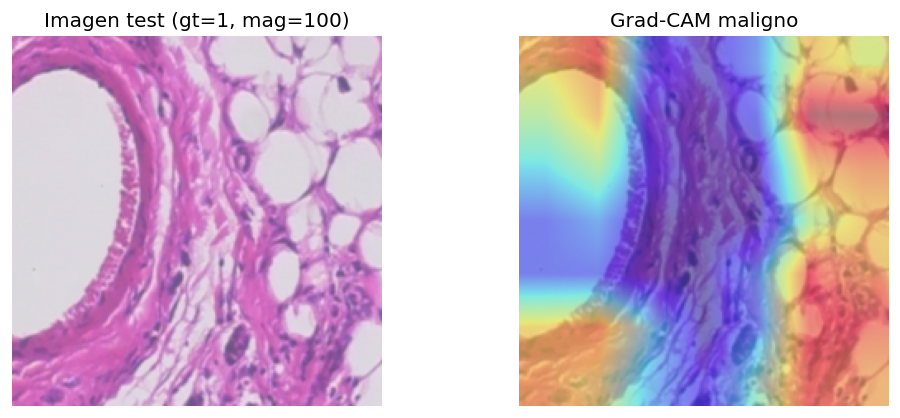

In [ ]:
import torch.nn.functional as F

def gradcam_resnet18(model, img_tensor, target_class=1):
    model.eval()
    feats = {}
    def hook(m, i, o): feats['featmap'] = o.detach()
    handle = model.layer4.register_forward_hook(hook)

    img_tensor = img_tensor.unsqueeze(0).to(device)
    model.zero_grad(set_to_none=True)
    out = model(img_tensor)
    out[0, target_class].backward()

    A = feats['featmap'][0]
    grads = model.layer4[1].conv2.weight.grad
    weights = torch.mean(grads, dim=(1,2,3)) if grads is not None else torch.ones(A.size(0))
    cam = torch.sum(weights[:, None, None] * A, dim=0).cpu().numpy()
    cam = np.maximum(cam, 0); cam = cam / (cam.max() + 1e-9)
    handle.remove()
    return cam

img, lab, mag, pid, path = test_ds[0]
cam = gradcam_resnet18(best_model, img, target_class=1)
orig = (img.permute(1,2,0).cpu().numpy() * np.array(STD) + np.array(MEAN))
orig = np.clip(orig, 0, 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(orig); plt.title(f'Imagen test (gt={lab}, mag={mag})'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(orig); plt.imshow(cv2.resize(cam, (IMG_SIZE, IMG_SIZE)), alpha=0.45, cmap='jet'); plt.title('Grad-CAM maligno'); plt.axis('off')
plt.show()


## Metricas a nivel pacient del modelo
- Primero como no tengo mas que solo los pesos del modelo en el .pth lo que haremos es cargar el modelo. NO volver a reentrenar


In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

def load_inference_model(filepath, num_classes=2):
    # Detectamos hardware disponible para asignar los tensores correctamente
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Instanciamos la arquitectura esqueleto (ResNet18)
    model = models.resnet18(weights=None)

    # 2. Ajustamos la "cabeza" del modelo para tus 2 clases (Benigno/Maligno)
    # Esto es crítico: si no coincide con el entrenamiento, la carga fallará.
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    # 3. Cargamos el diccionario de pesos (state_dict)
    # map_location asegura que no falle si entrenaste en GPU y cargas en CPU
    try:
        state_dict = torch.load(filepath, map_location=device)
        model.load_state_dict(state_dict)
        print(f"Pesos cargados exitosamente desde {filepath}")
    except RuntimeError as e:
        print(f"Error de coincidencia de capas. Verifica num_classes. Detalle: {e}")
        return None

    # Movemos el modelo al dispositivo y lo ponemos en modo evaluación
    model.to(device)
    model.eval()

    return model

# --- Ejecución ---
# Cargamos el modelo en la variable solicitada
model_cancer2 = load_inference_model('resnet18_focal_best.pth', num_classes=2)

# Verificación rápida
if model_cancer2:
    print("El modelo 'model_cancer2' está listo para inferencia.")

Error de coincidencia de capas. Verifica num_classes. Detalle: PytorchStreamReader failed reading zip archive: failed finding central directory
